This notebook shows how to forecast stock prices using machine learning and neural networks. In particular I chose GOOGL stock (Alphabet) and I will be using LSTM RNNs to predict future prices.

First download the dataset from the following link:
https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?resource=download&select=GOOGL_2006-01-01_to_2018-01-01.csv

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [14]:
stock_df = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv")
print(stock_df.head())

         Date    Open    High     Low   Close    Volume   Name
0  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
1  2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2  2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
3  2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
4  2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL


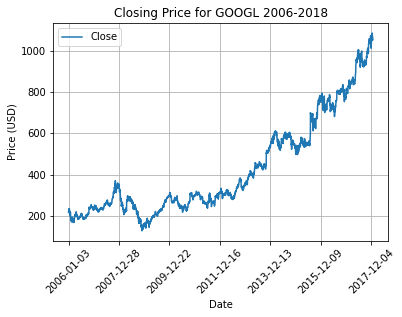

In [15]:
stock_df.plot(x='Date',y='Close',kind='line')
plt.title("Closing Price for GOOGL 2006-2018")
plt.xticks(rotation=45)
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

In [16]:
stock = stock_df[['Close']]
stock_std = (stock - stock.min(axis=0)) / (stock.max(axis=0) - stock.min(axis=0))
stock_scaled = stock_std * (1 - (-1)) + (-1)
print(stock_scaled.head())
print(stock_scaled.tail())

      Close
0 -0.813896
1 -0.803418
2 -0.797122
3 -0.782042
4 -0.780745
         Close
3014  0.966055
3015  0.959759
3016  0.947942
3017  0.939053
3018  0.933720


In [17]:
def split_train_test(dataset,percentage,lookback):
    data_raw = dataset.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data);
    train_size = int(percentage*data.shape[0])
    test_size = data.shape[0]-train_size
    
    x_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]
    
    x_test = data[train_size:,:-1]
    y_test = data[train_size:,-1,:]
    
    return x_train, y_train, x_test, y_test

x_train,y_train,x_test,y_test = split_train_test(stock_scaled,80,20)

In [19]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)